In [1]:
import time
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist
import ot

from ot.optim import semirelaxed_cg as s_ot
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from partial_relaxed_ot import p_rot as p_rot
from partial_relaxed_ot import compute_partial_reg_ot

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# np_config.register_backend(TensorflowBackend())
  
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

from utils import make_data
from utils import draw_p_u_dataset_scar



c:\Users\bilal\anaconda3\envs\pytorch\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
datasets = ['mushrooms', 'shuttle', 'pageblocks', 'usps',
            'connect-4', 'spambase', 'mnist', 'mnist-colored']

# datasets = ['mushrooms']

prior_lst = [0.518, 0.786, 0.898, 0.167, 0.658, 0.394, 0.1, 0.1]
penalties = ["l1", "l2"]
# penalties = ["l2"]
regs = [1e-2, 1e-1, 1e0, 1e1, 1e2]
# regs = [1e-2]
# regs = np.logspace(-2,2,20)

n_unl = 800
n_pos = 400
nb_reps = 10


results = {}
 
accuracies_avg = np.zeros([len(datasets), len(penalties), len(regs)])
ROC_AUC_avg = np.zeros([len(datasets), len(penalties), len(regs)])


for i in range(len(datasets)):
    for j in range(len(penalties)):
        for k in range(len(regs)):
            print("dataset", datasets[i])
            print("penalty", penalties[j])
            print("reg", regs[k] )
            
            if datasets[i] != "mnist-colored":
                ds_p = datasets[i]
                ds_ul = datasets[i]
            else:
                ds_p = 'mnist_color_change_p'
                ds_ul = 'mnist_color_change_u'
            
            prior = prior_lst[i]
                
            P_list, y_u_list, y_hat_list, nu_star_list = compute_partial_reg_ot(ds_p, ds_ul, n_pos, n_unl, prior, nb_reps, penalty=penalties[j], reg = 1/regs[k])
            results[datasets[i] + "_" + str(penalties[j]) + "_" + str(regs[k]) ] = (P_list, y_u_list, y_hat_list, nu_star_list)
            
            acc = []
            roc_auc = []
            for rep in range(nb_reps):
                acc.append(np.sum(y_hat_list[rep] == y_u_list[rep])/n_unl)
                roc_auc.append(roc_auc_score(y_u_list[rep], np.sum(P_list[rep], axis=0)))
            
            accuracies_avg[i, j, k] = np.mean(acc)
            ROC_AUC_avg[i, j, k] = np.mean(roc_auc)
            


dataset mushrooms
penalty l1
reg 0.01
dataset mushrooms
penalty l1
reg 0.1
dataset mushrooms
penalty l1
reg 1.0
dataset mushrooms
penalty l1
reg 10.0
dataset mushrooms
penalty l1
reg 100.0
dataset mushrooms
penalty l2
reg 0.01
dataset mushrooms
penalty l2
reg 0.1
dataset mushrooms
penalty l2
reg 1.0
dataset mushrooms
penalty l2
reg 10.0
dataset mushrooms
penalty l2
reg 100.0
dataset shuttle
penalty l1
reg 0.01
dataset shuttle
penalty l1
reg 0.1
dataset shuttle
penalty l1
reg 1.0
dataset shuttle
penalty l1
reg 10.0
dataset shuttle
penalty l1
reg 100.0
dataset shuttle
penalty l2
reg 0.01
dataset shuttle
penalty l2
reg 0.1
dataset shuttle
penalty l2
reg 1.0
dataset shuttle
penalty l2
reg 10.0
dataset shuttle
penalty l2
reg 100.0
dataset pageblocks
penalty l1
reg 0.01
dataset pageblocks
penalty l1
reg 0.1
dataset pageblocks
penalty l1
reg 1.0
dataset pageblocks
penalty l1
reg 10.0
dataset pageblocks
penalty l1
reg 100.0
dataset pageblocks
penalty l2
reg 0.01
dataset pageblocks
penalty l2
r

In [4]:
import pandas as pd
results_UCI = {'dataset': datasets,
               '$\pi$': prior_lst,
               'acc ': np.max(accuracies_avg[:,0,:], axis=1),
               'roc-auc': np.max(ROC_AUC_avg[:,0,:], axis=1),
               }
results_UCI = pd.DataFrame(data=results_UCI)
results_UCI


,dataset,$\pi$,acc,roc-auc
0,mushrooms,0.518,0.93450,0.976818
1,shuttle,0.786,0.94350,0.969108
2,pageblocks,0.898,0.92100,0.839229
3,usps,0.167,0.96800,0.966662
4,connect-4,0.658,0.58300,0.586735
5,spambase,0.394,0.75675,0.783239
6,mnist,0.100,0.98800,0.986180
7,mnist-colored,0.100,0.91375,0.782228


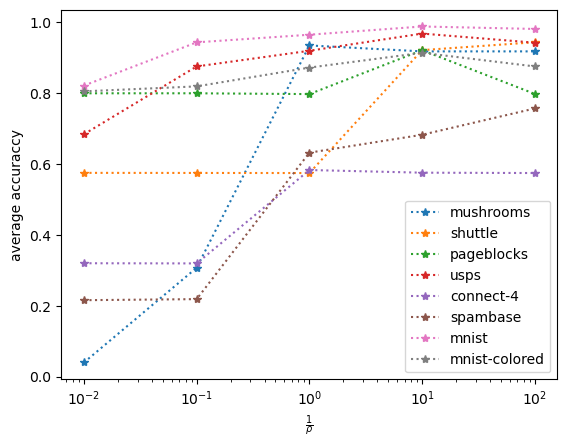

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.semilogx(regs, accuracies_avg[:,0,:].T, ":*", label = datasets)
ax.set_xlabel("$\\\rho}$")
ax.set_ylabel("average accuraccy")
ax.legend()

In [7]:
import pandas as pd
results_UCI = {'dataset': datasets,
               '$\pi$': prior_lst,
               'acc ': np.max(accuracies_avg[:,1,:], axis=1),
               'roc-auc': np.max(ROC_AUC_avg[:,1,:], axis=1),
               }
results_UCI = pd.DataFrame(data=results_UCI)
results_UCI

,dataset,$\pi$,acc,roc-auc
0,mushrooms,0.518,0.98050,0.993328
1,shuttle,0.786,0.96650,0.988262
2,pageblocks,0.898,0.92425,0.891061
3,usps,0.167,0.98900,0.995498
4,connect-4,0.658,0.60150,0.591539
5,spambase,0.394,0.81625,0.885631
6,mnist,0.100,0.99175,0.996795
7,mnist-colored,0.100,0.92300,0.883751


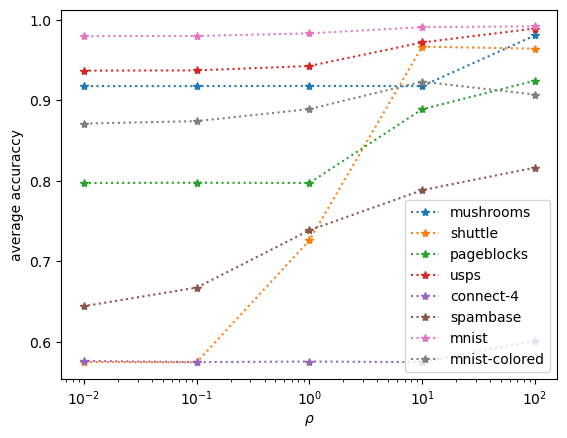

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.semilogx(regs, accuracies_avg[:,1,:].T, ":*", label = datasets)
ax.set_xlabel("$\\rho}$")
ax.set_ylabel("average accuraccy")
ax.legend()

In [13]:
regs

[0.01, 0.1, 1.0, 10.0, 100.0]